This is an example of how we can perform some Content-Base filtering approach on meta-data information for generating recommendations.

We will load the file: books_n_description.csv. Then will perform a short EDA followed by TFIDF based recommendation. 

First, we will generate a recommendation base upon item2item similarity.
Second, we will generate recommendations for a given user.

#Imports

In [75]:
import numpy as np
import pandas as pd
import random
import os

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [77]:
#Make sure you downloaded the dataset and you create such a path, alternativly - changed this path
PATH = '/content/drive/My Drive/Recommender Systems/Content Base/Datasets/Book-Crossing'
os.chdir(PATH)

In [78]:
!ls

Books.csv		 books_n_description.gsheet  final_books.xlsx
books_n_description.csv  BX-Book-Ratings.csv	     ratings_expl.csv


In [81]:
# Load data from csv file
# items_desc = pd.read_excel('final_books.xlsx',index_col=0)
items_desc = pd.read_csv('books_n_description.csv',encoding='latin-1',index_col=0)
items_desc['ISBN'] = items_desc['ISBN'].astype(str)
items_desc['description'] = items_desc['description'].fillna(items_desc['title'])
items_desc['description'] = items_desc['description'].astype(str) 
items_desc_isbn = items_desc.set_index('ISBN') 
# print the first 5 rows of the data
items_desc.head()

,ISBN,title,author,pub_year,publisher,categories,description
0,2005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,Actresses,"In a small town in Canada, Clara Callan reluct..."
1,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,Medical,"Describes the great flu epidemic of 1918, an o..."
2,399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,Fiction,A Chinese immigrant who is convinced she is dy...
3,440234743,The Testament,John Grisham,1999.0,Dell,Fiction,"A suicidal billionaire, a burnt-out Washington..."
4,452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,Fiction,Staring unflinchingly into the abyss of slaver...


We want to extend the information from the last notebook with this external information. (rating and metadata information)
We have to check that the same ISBN codes are in all files.

Hence, we will build a function that will filter all the ISBN codes that do not appear in the internal and external data.

In [82]:
def filter_data_to_relevant_isbn(df,lead_df):
    """
    prequesition: df and lead_df must have 'isbn' column.
    1) This method will set the index of the df to be the isbn.
    2) Filter out all the isbn which do not appear in lead_df (external data)
    3) return a filtered dataframe with isbn as the index.    

    Parameters
        ----------
        df : DataFrame            
        lead_df : DataFrame           
    """
    df = df.set_index('ISBN')
    lead_df = lead_df.set_index('ISBN')
    print('shape before filtering: ',df.shape)
    df = df.loc[df.index.isin(lead_df.index)]
    print('shape after filtering: ',df.shape)
    return df
    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


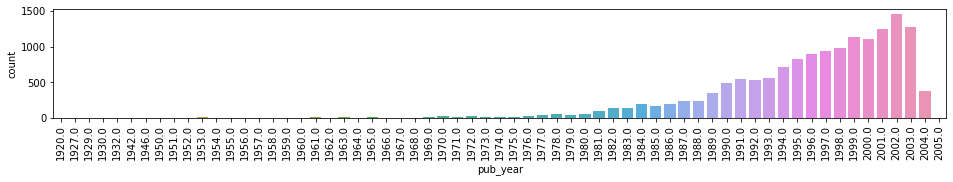

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,2))
plt.xticks(rotation=90)

sns.countplot(items_desc['pub_year'])




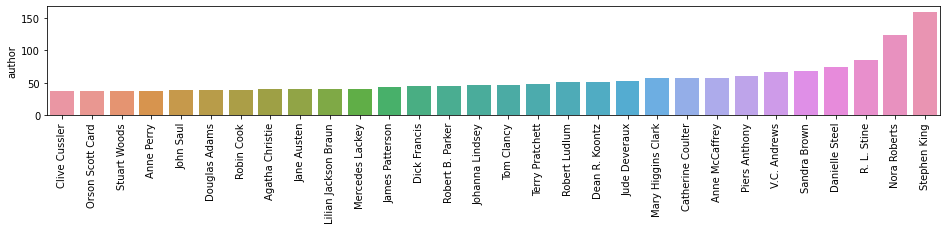

In [84]:
top_authors = items_desc['author'].value_counts().head(30)
top_authors = top_authors.iloc[::-1] 

plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
sns.barplot(x = top_authors.index ,y=top_authors)



# Load Explicit Feedback

In [85]:
# Load explicit rating file.
ratings_expl = pd.read_csv(os.path.join(PATH,'ratings_expl.csv'),names=['userID','ISBN','rating'],encoding='latin-1',sep=';',skiprows=1)
ratings_expl['ISBN'] = ratings_expl['ISBN'].astype(str)
ratings_expl_filtered = filter_data_to_relevant_isbn(ratings_expl,items_desc)
ratings_expl_filtered['rating'] = ratings_expl_filtered['rating'].astype(int)

ratings_expl_filtered.head()

shape before filtering:  (340047, 2)
shape after filtering:  (23116, 2)


,userID,rating
ISBN,,
038550120X,276744,7
3442136644,276774,9
043935806X,276788,7
3548603203,276798,6
2253150711,276828,7


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


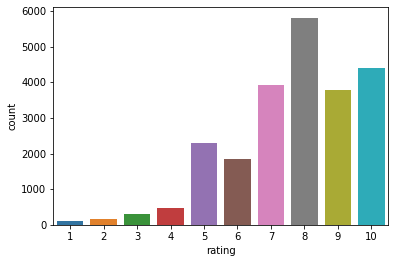

In [86]:
sns.countplot(ratings_expl_filtered['rating'])

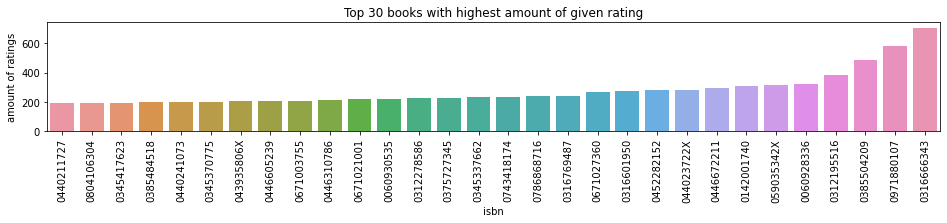

In [87]:
top_isbn = ratings_expl['ISBN'].value_counts().head(30)
top_isbn = top_isbn.iloc[::-1] 

plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
ax = sns.barplot(x = top_isbn.index ,y=top_isbn)
ax.set(xlabel='isbn', ylabel='amount of ratings',title='Top 30 books with highest amount of given rating')

plt.show()





# TFIDF - build upon description

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Creating a TfidfVectorizer object
tf_vector = TfidfVectorizer(stop_words='english',min_df=5,ngram_range=(1,2))
# transform each book description
x = tf_vector.fit_transform(items_desc['description'])

# Convert the TfidfVectorizer fit results into a table and display first 5 rows
tf_vector_df = pd.DataFrame(x.toarray(), columns=tf_vector.get_feature_names())
tf_vector_df.head()


,000,000 ad,000 printing,10,100,100 000,101,101 stories,11,12,13,14,15,150,150 000,16,17,18,19,1930s,1950s,1960s,1970s,1984,1996,1998,1999,20,20 000,2000,2001,20th,20th century,21,21st,21st century,22,24,25,27,...,wrong,wrote,wuthering,wuthering heights,wyoming,xanth,ya,yankee,year,year old,yearling,yearling newbery,years,years ago,years earlier,years later,years old,yellow,yes,yesterday,york,york city,york times,young,young boy,young daughter,young girl,young man,young woman,young women,younger,youth,zebra,zebra historical,zen,zen art,zero,zone,zu,â¼r
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.08796,0.0,0.0,0.075427,0.0,0.0,0.0,0.0,0.0,0.123582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192661,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.127454,0.0,0.0,0.18212,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Next, we will create a cosine similarity matrix between all items
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(x, x)

In [90]:
# We will create a dictionary indicating the most similar results for each item.

results = {} # dictionary created to store the result in a dictionary format (ID : (Score,item_id))#
df_merge2 = items_desc.reset_index().rename(columns={items_desc.index.name:'ISBN'})
for idx, row in df_merge2.iterrows(): #iterates through all the rows   
    
# the below code 'similar_indice' stores similar ids based on cosine similarity. sorts them in ascending order. [:-5:-1] is then used so that the indices with most similarity are got. 0 means no similarity and 1 means perfect similarity#
    similar_indices = cosine_similarities[idx].argsort()[:-5:-1] 

    #stores 5(including itself) most similar books, you can change it as per your needs
    similar_items = [( df_merge2['ISBN'][i],cosine_similarities[idx][i]) for i in similar_indices]
    results[row['ISBN']] = similar_items[1:]

In [179]:
def recommend_item2item(ISBN, num, similarity_dict):
    """
    This function will generate item2item recommendation build TFIDF similarity.
   
    Parameters
        ----------
        ISBN : str, a book serial number
        num : int, number of recommendations
        similarity_dict: dictionary with TFIDF similarty scores for each item.
    """

    if (num == 0):
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")           
    else :        
        print("Recommending " + str(num) + " books similar to " + "ISBN: ")
        
        
    print("----------------------------------------------------------")    
    recs = similarity_dict[ISBN][:num]    
    for rec in recs:        
        print("You may also like to read: " + 'ISBN: ' + str(rec[0]) +'\t score:' + str(rec[1]) + '\n')
        print (items_desc_isbn.loc[(str(rec[0]))])
        print('\n')
            



In [181]:
recommend_item2item('304345350',2,results)

Recommending 2 books similar to ISBN: 
----------------------------------------------------------
You may also like to read: ISBN: 446342963	 score:0.6861919730782218

title          Dreamer's Dictionary
author                  Tom Corbett
pub_year                       1986
publisher              Warner Books
categories                      NaN
description    Dreamer's Dictionary
Name: 446342963, dtype: object


You may also like to read: ISBN: 067174559X	 score:0.633209619186057

title          The Klingon Dictionary (Star Trek: All)
author                                     Marc Okrand
pub_year                                          1992
publisher                                    Star Trek
categories                                         NaN
description    The Klingon Dictionary (Star Trek: All)
Name: 067174559X, dtype: object




In [123]:
def recommand_item2user (userID,similarity_dict):
    """ 
    This function will utilize all previous interactions of given user metadata. 
    First, we will get all previous books read by the userID.
    Next, we will filter all available books according to:
    1) minimum and maximum pub_year read by the user
    2) authors appeared in previous read books
    3) available books must not include books already read by the user.
    Next, for each remaining candidate, we will generate recommendations and extend these recommendation according to the dictionary. 
    The value of the dictionary is a tuple (similarity_score, original_item_to_recommend).

    Last, we will print all recommendations.


        Parameters
        ----------
        userID : integer
            The user ID
        similarity_dict : dictionary of similarity base one TFIDF.             
        
        """
    
    # Get previous metadata relevant to given userID
    past_isbn = ratings_expl_filtered[ratings_expl_filtered['userID'] == userID].index    
    max_year = max(items_desc_isbn.loc[past_isbn]['pub_year'])
    min_year = min(items_desc_isbn.loc[past_isbn]['pub_year'])    
    past_authors = items_desc_isbn.loc[past_isbn]['author'].unique()
    candidate_df = items_desc_isbn[~items_desc_isbn.index.isin(past_isbn)]   
    
    candidate_df = candidate_df[candidate_df['pub_year'].between(min_year,max_year,inclusive=True)]
    candidate_df = candidate_df[candidate_df['author'].isin(past_authors)]
    
    # Generate recommendations for each item read by the user
    recs = {}
    for item_id in past_isbn:
        item_recommend = results[item_id]
        recs.update(dict(item_recommend)) 
    
    # Use only recommendations which are considered as candidates
    sorted_recs = sorted(recs.items(), key=lambda kv: kv[1],reverse=True)    
    candidate_df = candidate_df.loc[candidate_df.index.isin(recs.keys())]            
    recommend_items_remain = np.unique(candidate_df.index.values)    
    
    # Extend the recommendation build upon the similarity_dict 
    recommendation_scores = {}
    for rec in recommend_items_remain:                        
        for similar_item in similarity_dict[rec]:
            rec_isbn = similar_item[0]
            rec_score = similar_item[1]
            if rec_isbn not in recommendation_scores:
                recommendation_scores[rec_isbn] = (rec_score,rec)

            elif (recommendation_scores[rec_isbn][0] >rec_score):
                     recommendation_scores[rec_isbn] = (recommendation_scores[rec_isbn][0],rec)            
     
    print("Build upon previous interactions you may also like to read:")
    for rec in recommend_items_remain:
        print('isbn: ' + rec)
        print(items_desc_isbn.loc[rec])
        print('\n')
    
    print('**********************************************************')
    print("We extend our recommendation by utilizing TFIDF")
    print("Therefore, you may also like to read: ")
    print('**********************************************************')
    
    for key in recommendation_scores:        
        if ((key not in past_isbn.values) and (key not in recommend_items_remain )):            
            print('isbn: ' + key +'\t score:' + str(recommendation_scores[key]))
            print(items_desc_isbn.loc[key])
            print('\n')
            
    
        
    
    
    
    

Let's demonstrate the usage of this recommendations method.

In [182]:
# We will see which ISBN were read by a given user. 
userID = 709
items_desc_isbn.loc[ratings_expl_filtered[ratings_expl_filtered['userID'] == userID].index]

,title,author,pub_year,publisher,categories,description
ISBN,,,,,,
015216250X,So You Want to Be a Wizard: The First Book in ...,Diane Duane,2001.0,Magic Carpet Books,Fantasy,"During a summer vacation at the beach, thirtee..."


In [175]:
recommand_item2user(userID = 709,similarity_dict=results)

Build upon previous interactions you may also like to read:
isbn: 152162577
title          Deep Wizardry: The Second Book in the Young Wi...
author                                               Diane Duane
pub_year                                                    2001
publisher                                     Magic Carpet Books
categories                                      Juvenile Fiction
description    During a summer vacation at the beach, thirtee...
Name: 152162577, dtype: object


**********************************************************
We extend our recommendation by utilizing TFIDF
Therefore, you may also like to read: 
**********************************************************
isbn: 345274563	 score:(0.468462103068382, '152162577')
title          Her Majesty's Wizard
author         Christopher Stasheff
pub_year                       1996
publisher             Del Rey Books
categories                      NaN
description    Her Majesty's Wizard
Name: 345274563, dtype: 

In [183]:
# Let's check another example.
userID = 276847
items_desc_isbn.loc[ratings_expl_filtered[ratings_expl_filtered['userID'] == userID].index]

,title,author,pub_year,publisher,categories,description
ISBN,,,,,,
3404148576,Nordermoor,Arnaldur Indridason,2003.0,LÃ?ÃÂ¼bbe,NaN,Nordermoor
3423071516,Der Kleine Hobbit,J. R. R. Tolkien,2002.0,Distribooks,NaN,Der Kleine Hobbit
3442413508,Auf Ehre und Gewissen. Roman.,Elizabeth George,1992.0,Goldmann,NaN,Auf Ehre und Gewissen. Roman.
3442437717,Asche zu Asche.,Elizabeth George,1997.0,Goldmann,NaN,Asche zu Asche.
3442444020,Denn sie betrÃ?ÃÂ¼gt man nicht.,Elizabeth George,1999.0,Goldmann,NaN,Denn sie betrÃ?ÃÂ¼gt man nicht.
3442446414,Mit dem KÃ?ÃÂ¼hlschrank durch Irland.,Tony Hawks,2000.0,Goldmann,NaN,Mit dem KÃ?ÃÂ¼hlschrank durch Irland.
3442448530,Die HirnkÃ?ÃÂ¶nigin.,Thea Dorn,2001.0,Goldmann,NaN,Die HirnkÃ?ÃÂ¶nigin.
3551551677,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,NaN,Harry Potter und der Stein der Weisen
3551551685,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,NaN,Harry Potter und die Kammer des Schreckens


We can observe that this user read some Sci-Fi books. For example, several different Harry Potter Books.

Next, we will generate recommendation for this user.

In [184]:
recommand_item2user(userID = 276847,similarity_dict=results)

Build upon previous interactions you may also like to read:
isbn: 2070518426
title          Harry Potter a l'ecole des sorciers
author                               J. K. Rowling
pub_year                                      1999
publisher                       Gallimard Jeunesse
categories                                     NaN
description    Harry Potter a l'ecole des sorciers
Name: 2070518426, dtype: object


isbn: 439139597
title          Harry Potter and the Goblet of Fire (Book 4)
author                                        J. K. Rowling
pub_year                                               2000
publisher                                        Scholastic
categories                                              NaN
description    Harry Potter and the Goblet of Fire (Book 4)
Name: 439139597, dtype: object


**********************************************************
We extend our recommendation by utilizing TFIDF
Therefore, you may also like to read: 
****************************

As observed, some of the recommended items are Harry Potter's books as well. 

***Limitation:*** According to our algorithm, we cannot understand that two different ISBN are the same book in a different language. 


Therefore, it is important to invest time in the preprocessing phase.

As self-practice, you can now try to apply some preprocessing or a more complicated algorithm for generating recommendations.

# Fix the bug
Can you think about what did not work as suppose to ? 
Let's look at the following example: 

In [187]:
recommand_item2user(userID = 735,similarity_dict=results)

Build upon previous interactions you may also like to read:
**********************************************************
We extend our recommendation by utilizing TFIDF
Therefore, you may also like to read: 
**********************************************************


We did not get any recommendations. Can you think why? 
Can you fix this ? 